# PU BDT rejection features inspection - INCLUSIVE

Check that the PU from RelValNu, RelValTau and RelValQCD have the same distributions of features.

This proves that they are homogeneous and then we can use all of them to train the PU rejection

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb
import matplotlib
import pickle
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [3]:
def plotter(df, variable, bins):
    purePU = df.query('gentau_decayMode==-1')
    tauPU  = df.query('gentau_decayMode==-99.9')
    qcdPU  = df.query('gentau_decayMode==-2')
    
    plt.figure(figsize=(8,8))
    plt.hist(purePU[variable], alpha=0.5, label='purePU', bins=bins, histtype='step', lw=2, density=True)
    plt.hist(tauPU[variable], alpha=0.5, label='tauPU', bins=bins, histtype='step', lw=2, density=True)
    plt.hist(qcdPU[variable], alpha=0.5, label='qcdPU', bins=bins, histtype='step', lw=2, density=True)
    plt.legend()
    plt.xlabel(variable)
    plt.ylabel('a.u.')
    plt.show()

In [4]:
indir = '/home/llr/cms/motta/HGCAL/CMSSW_11_1_0/src/GRAPHAnalysis/L1BDT/hdf5dataframes/matched'

name = 'threshold'
    
# define the input and output dictionaries for the handling of different datasets
inFileTraining_dict = {
    'threshold'    : indir+'/Training_PU200_th_matched.hdf5',
    'mixed'        : indir+'/'
}

dfTraining_dict = {}

In [5]:
store_tr = pd.HDFStore(inFileTraining_dict[name], mode='r')
dfTraining_dict[name] = store_tr[name]
store_tr.close()
dfTraining_dict[name]['cl3d_abseta'] = np.abs(dfTraining_dict[name]['cl3d_eta'])
        
# here we apply minimal requirements so that we are working in a fiducial region slightly smaller than the full HGCAL acceptance
# we apply the OR between tau, jet, and cluster requirements
#dfTraining_dict[name].query('(cl3d_pt>4 and cl3d_abseta>1.6 and cl3d_abseta<2.9) or ((gentau_vis_pt>20 and ((gentau_vis_eta>1.6 and gentau_vis_eta<2.9) or (gentau_vis_eta<-1.6 and gentau_vis_eta>-2.9))) or (genjet_pt>20 and ((genjet_eta>1.6 and genjet_eta<2.9) or (genjet_eta<-1.6 and genjet_eta>-2.9))))', inplace=True)
dfTraining_dict[name].query('cl3d_pt>4 or gentau_vis_pt>20 or genjet_pt>20', inplace=True)

# for the actual training and validation we enforce the AND between tau and cluster requirements
dfTr = dfTraining_dict[name].copy(deep=True)

In [6]:
dfPU = dfTr.query('geom_match==False').copy(deep=True)
dfTau = dfTr.query('gentau_decayMode>=0 and cl3d_isbestmatch==True').copy(deep=True)

# keep only the needed stuff
keep = ['cl3d_pt', 'cl3d_phi', 'cl3d_abseta', 'cl3d_showerlength','cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_szz', 'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean', 'cl3d_hoe', 'cl3d_meanz', 'gentau_decayMode']
dfPU = dfPU[keep]
dfTau = dfTau[keep]

In [7]:
print('tot', dfTr.query('(geom_match==False) or (gentau_decayMode>=0 and cl3d_isbestmatch==True)').shape[0])
print('pu', dfPU.shape[0])
print('tau', dfTau.shape[0])

tot 7365043
pu 7342762
tau 22281


In [8]:
dfPU.groupby('gentau_decayMode').count()

,cl3d_pt,cl3d_phi,cl3d_abseta,cl3d_showerlength,cl3d_coreshowerlength,cl3d_firstlayer,cl3d_szz,cl3d_seetot,cl3d_spptot,cl3d_srrtot,cl3d_srrmean,cl3d_hoe,cl3d_meanz
gentau_decayMode,,,,,,,,,,,,,
-99.9,1870694,1870694,1870694,1870694,1870694,1870694,1870694,1870694,1870694,1870694,1870694,1870694,1870694
-2.0,4456340,4456340,4456340,4456340,4456340,4456340,4456340,4456340,4456340,4456340,4456340,4456340,4456340
-1.0,1015728,1015728,1015728,1015728,1015728,1015728,1015728,1015728,1015728,1015728,1015728,1015728,1015728


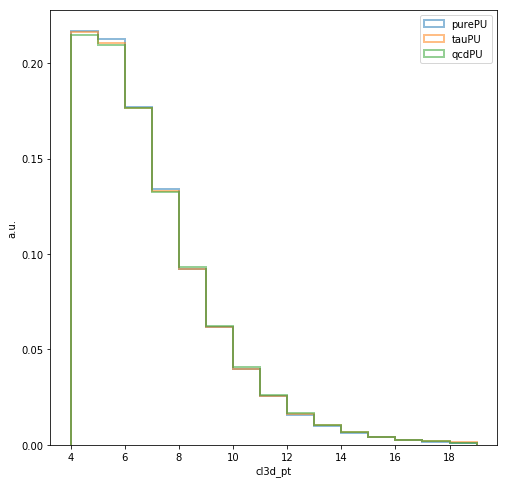

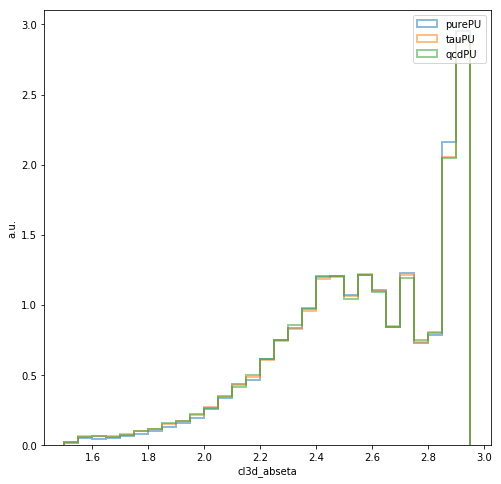

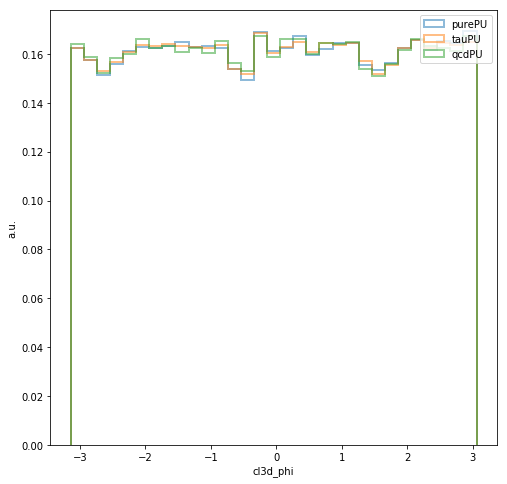

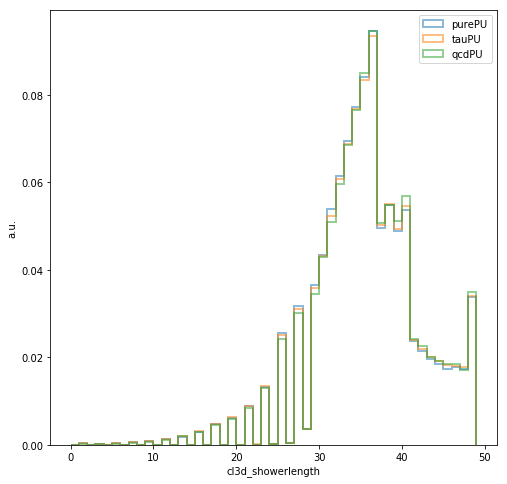

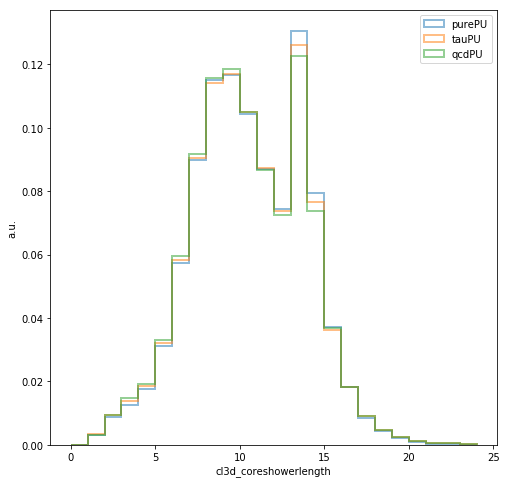

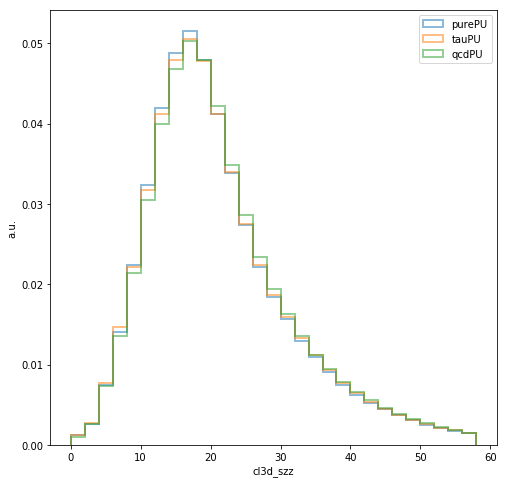

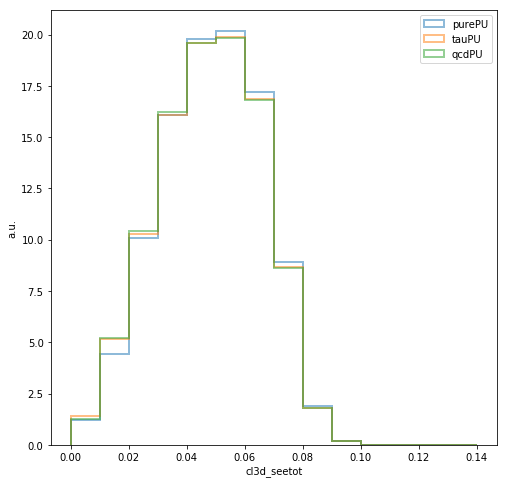

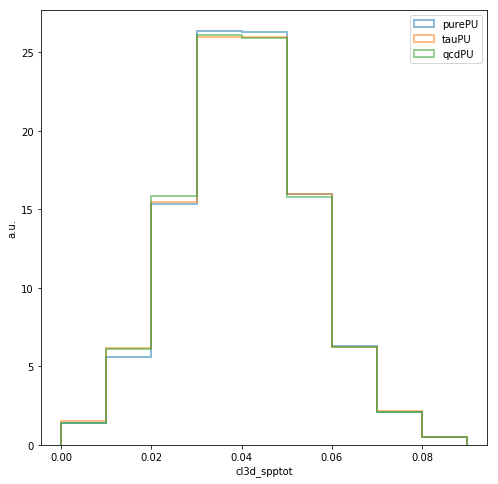

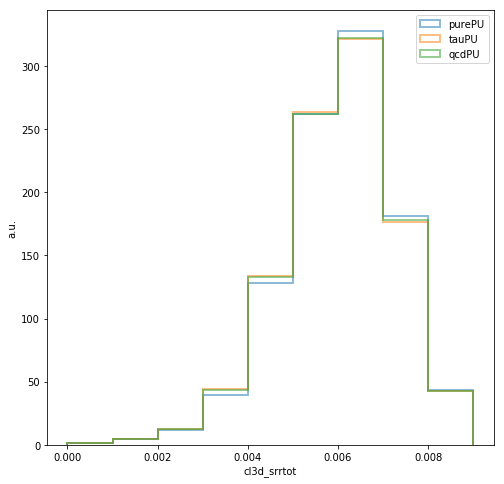

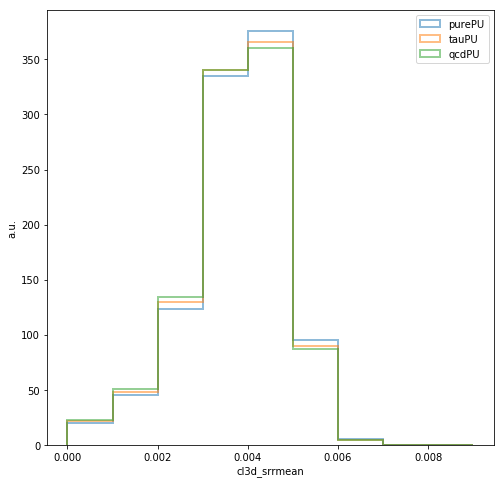

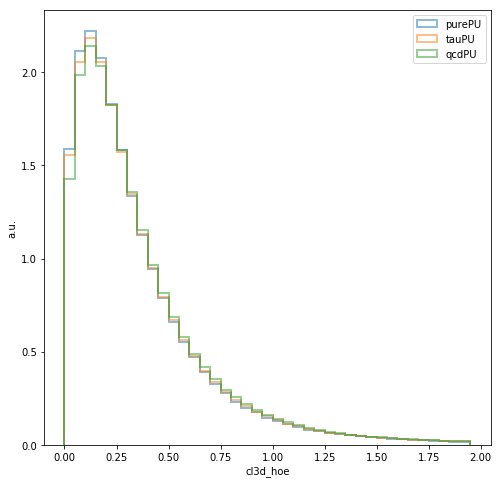

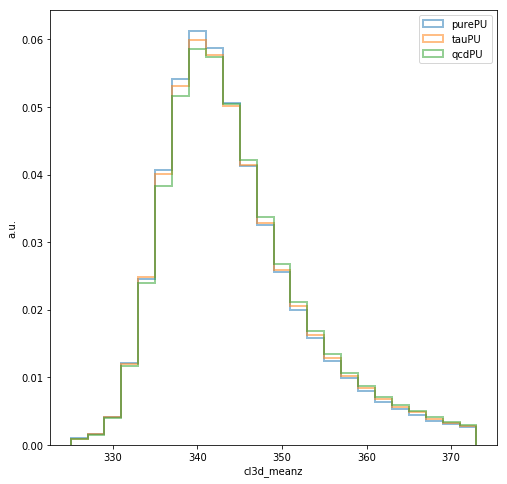

In [9]:
plotter(dfPU, 'cl3d_pt', np.arange(4,20,1))
plotter(dfPU, 'cl3d_abseta', np.arange(1.5,3.0,0.05))
plotter(dfPU, 'cl3d_phi', np.arange(-3.14,3.14,0.2))
plotter(dfPU, 'cl3d_showerlength', np.arange(0,50,1))
plotter(dfPU, 'cl3d_coreshowerlength', np.arange(0,25,1))
plotter(dfPU, 'cl3d_szz', np.arange(0,60,2))
plotter(dfPU, 'cl3d_seetot', np.arange(0,0.15,0.01))
plotter(dfPU, 'cl3d_spptot', np.arange(0,0.1,0.01))
plotter(dfPU, 'cl3d_srrtot', np.arange(0,0.01,0.001))
plotter(dfPU, 'cl3d_srrmean', np.arange(0,0.01,0.001))
plotter(dfPU, 'cl3d_hoe', np.arange(0,2,0.05))
plotter(dfPU, 'cl3d_meanz', np.arange(325,375,2))

# PU BDT rejection features inspection - SECTIONED

Check how the features differ in different eta regions

In [14]:
def plotter2(df, variable, bins):
    lowEta = df.query('cl3d_abseta >= 1.5 and cl3d_abseta <= 2.1').copy(deep=True)
    midEta = df.query('cl3d_abseta > 2.1 and cl3d_abseta <= 2.8').copy(deep=True)
    highEta = df.query('cl3d_abseta > 2.8 and cl3d_abseta <= 3.0').copy(deep=True)
    
    plt.figure(figsize=(8,8))
    plt.hist(lowEta[variable], alpha=0.5, label='lowEtalowEta', bins=bins, histtype='step', lw=2, density=True)
    plt.hist(midEta[variable], alpha=0.5, label='midEta', bins=bins, histtype='step', lw=2, density=True)
    plt.hist(highEta[variable], alpha=0.5, label='highEta', bins=bins, histtype='step', lw=2, density=True)
    plt.legend()
    plt.xlabel(variable)
    plt.ylabel('a.u.')
    plt.show()

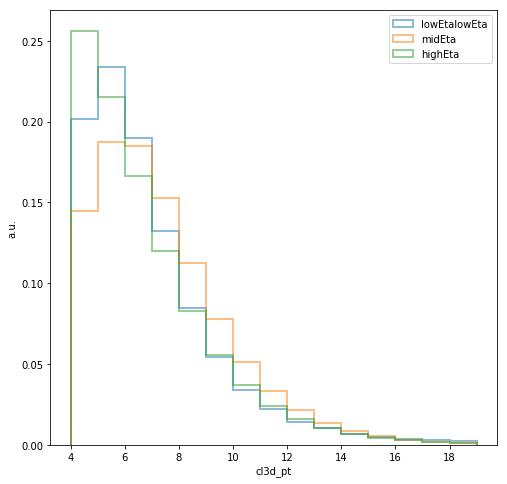

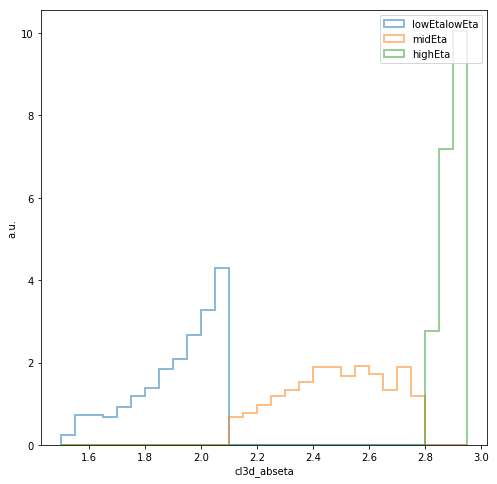

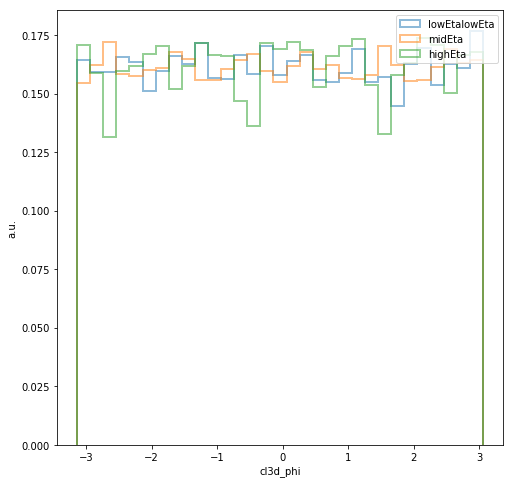

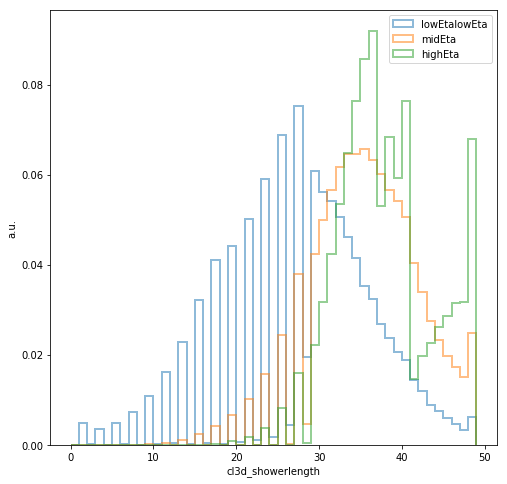

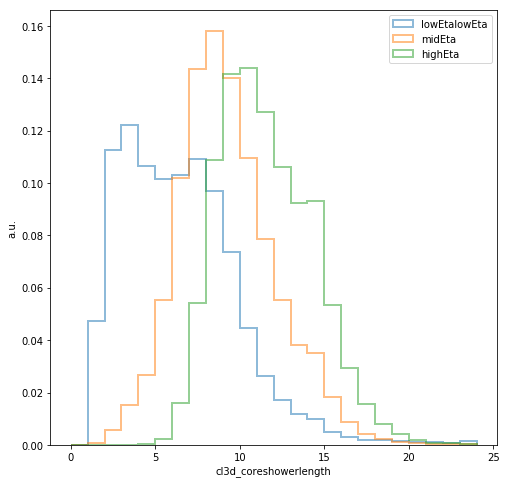

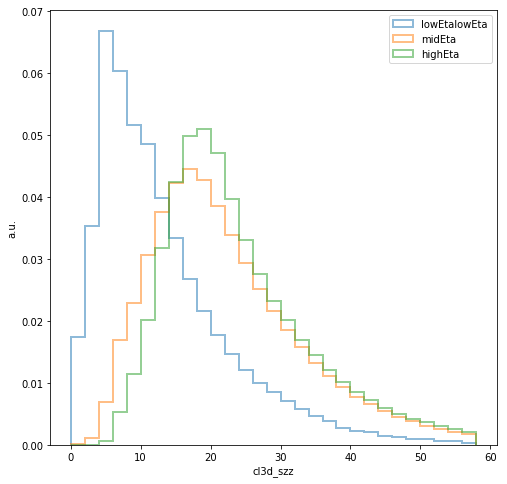

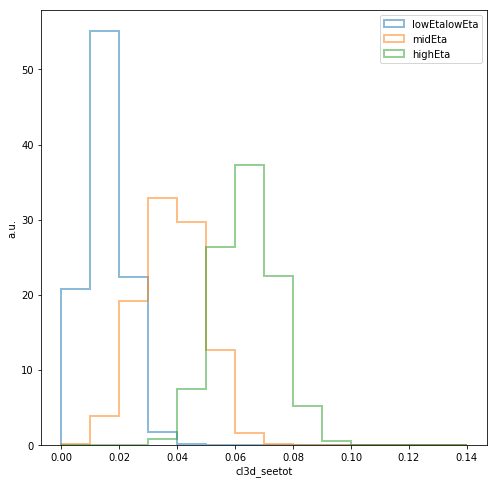

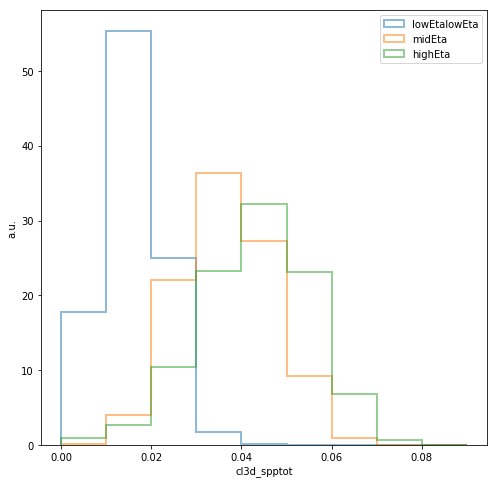

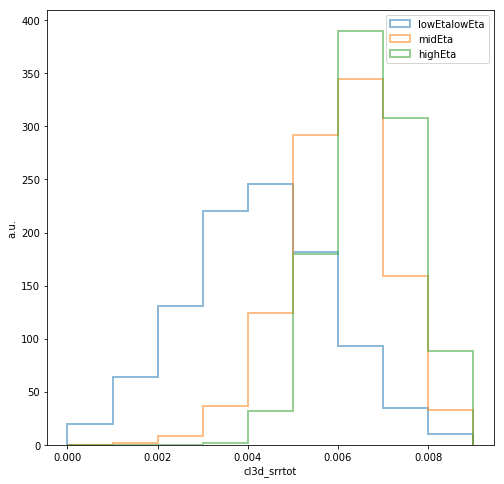

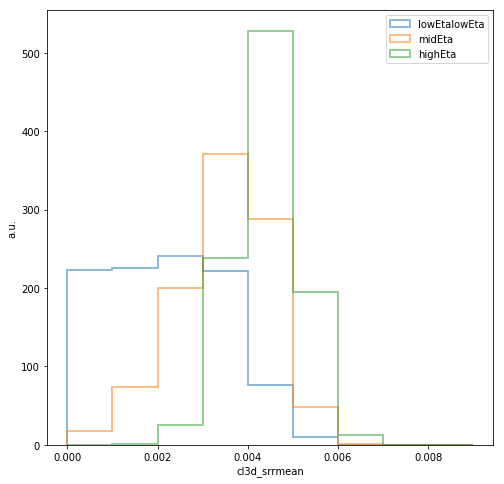

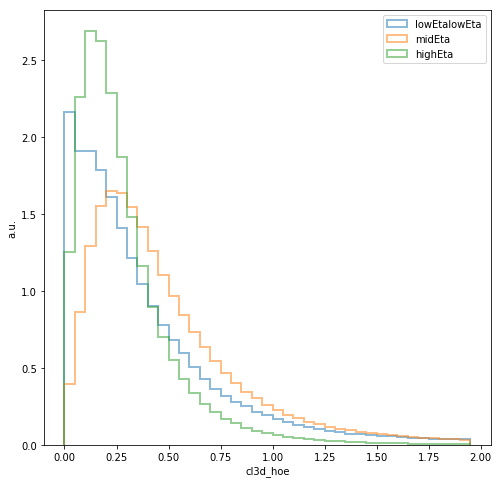

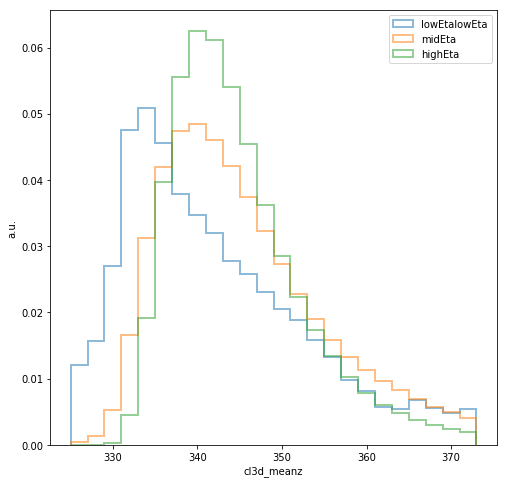

In [12]:
plotter2(dfPU, 'cl3d_pt', np.arange(4,20,1))
plotter2(dfPU, 'cl3d_abseta', np.arange(1.5,3.0,0.05))
plotter2(dfPU, 'cl3d_phi', np.arange(-3.14,3.14,0.2))
plotter2(dfPU, 'cl3d_showerlength', np.arange(0,50,1))
plotter2(dfPU, 'cl3d_coreshowerlength', np.arange(0,25,1))
plotter2(dfPU, 'cl3d_szz', np.arange(0,60,2))
plotter2(dfPU, 'cl3d_seetot', np.arange(0,0.15,0.01))
plotter2(dfPU, 'cl3d_spptot', np.arange(0,0.1,0.01))
plotter2(dfPU, 'cl3d_srrtot', np.arange(0,0.01,0.001))
plotter2(dfPU, 'cl3d_srrmean', np.arange(0,0.01,0.001))
plotter2(dfPU, 'cl3d_hoe', np.arange(0,2,0.05))
plotter2(dfPU, 'cl3d_meanz', np.arange(325,375,2))

In [28]:
def plotter3(dfPU, dfTau, variable, bins):
    lowEtaPU = dfPU.query('cl3d_abseta >= 1.5 and cl3d_abseta <= 2.1').copy(deep=True)
    midEtaPU = dfPU.query('cl3d_abseta > 2.1 and cl3d_abseta <= 2.8').copy(deep=True)
    highEtaPU = dfPU.query('cl3d_abseta > 2.8 and cl3d_abseta <= 3.0').copy(deep=True)
    
    lowEtaTau = dfTau.query('cl3d_abseta >= 1.5 and cl3d_abseta <= 2.1').copy(deep=True)
    midEtaTau = dfTau.query('cl3d_abseta > 2.1 and cl3d_abseta <= 2.8').copy(deep=True)
    highEtaTau = dfTau.query('cl3d_abseta > 2.8 and cl3d_abseta <= 3.0').copy(deep=True)
    
    fig = plt.figure(figsize = (24, 8))
    ax0 = fig.add_subplot(141)
    ax1 = fig.add_subplot(142)
    ax2 = fig.add_subplot(143)
    ax3 = fig.add_subplot(144)
    
    ax0.hist(dfPU[variable], alpha=0.5, label='inclusive PU', bins=bins, histtype='step', lw=2, density=True)
    ax0.hist(dfTau[variable], alpha=0.5, label='inclusive Tau', bins=bins, histtype='step', lw=2, density=True)
    ax0.legend()
    ax0.set_xlabel(variable)
    ax0.set_ylabel('a.u.')
    ax1.hist(lowEtaPU[variable], alpha=0.5, label='lowEta PU', bins=bins, histtype='step', lw=2, density=True)
    ax1.hist(lowEtaTau[variable], alpha=0.5, label='lowEta Tau', bins=bins, histtype='step', lw=2, density=True)
    ax1.legend()
    ax1.set_xlabel(variable)
    ax1.set_ylabel('a.u.')
    ax2.hist(midEtaPU[variable], alpha=0.5, label='midEta PU', bins=bins, histtype='step', lw=2, density=True)
    ax2.hist(midEtaTau[variable], alpha=0.5, label='midEta Tau', bins=bins, histtype='step', lw=2, density=True)
    ax2.legend()
    ax2.set_xlabel(variable)
    ax2.set_ylabel('a.u.')
    ax3.hist(highEtaPU[variable], alpha=0.5, label='highEta PU', bins=bins, histtype='step', lw=2, density=True)
    ax3.hist(highEtaTau[variable], alpha=0.5, label='highEta Tau', bins=bins, histtype='step', lw=2, density=True)
    ax3.legend()
    ax3.set_xlabel(variable)
    ax3.set_ylabel('a.u.')
    
    plt.show()

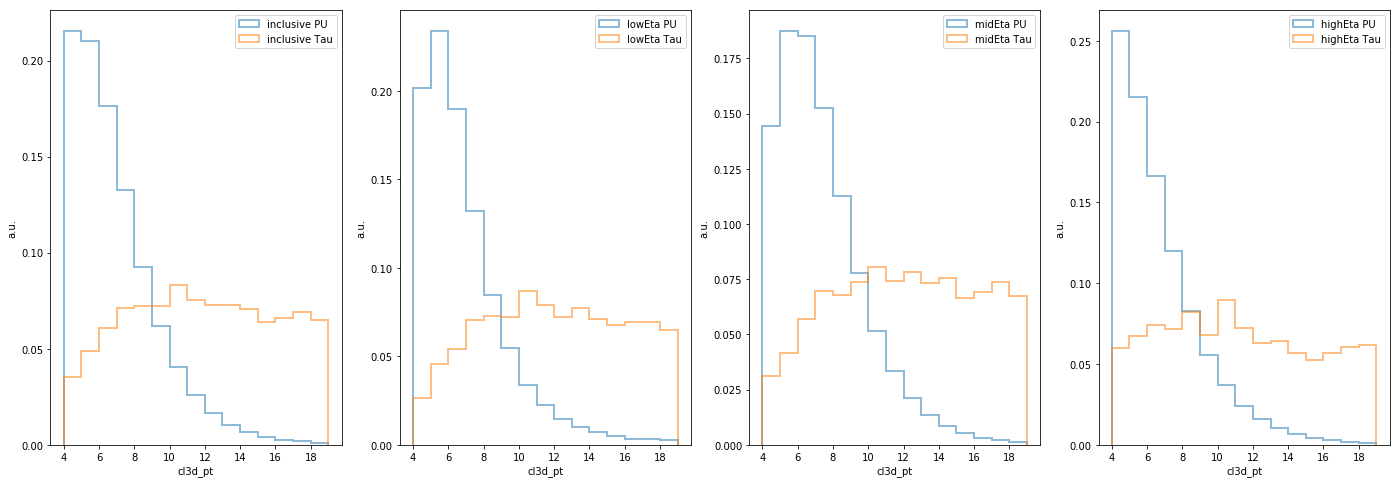

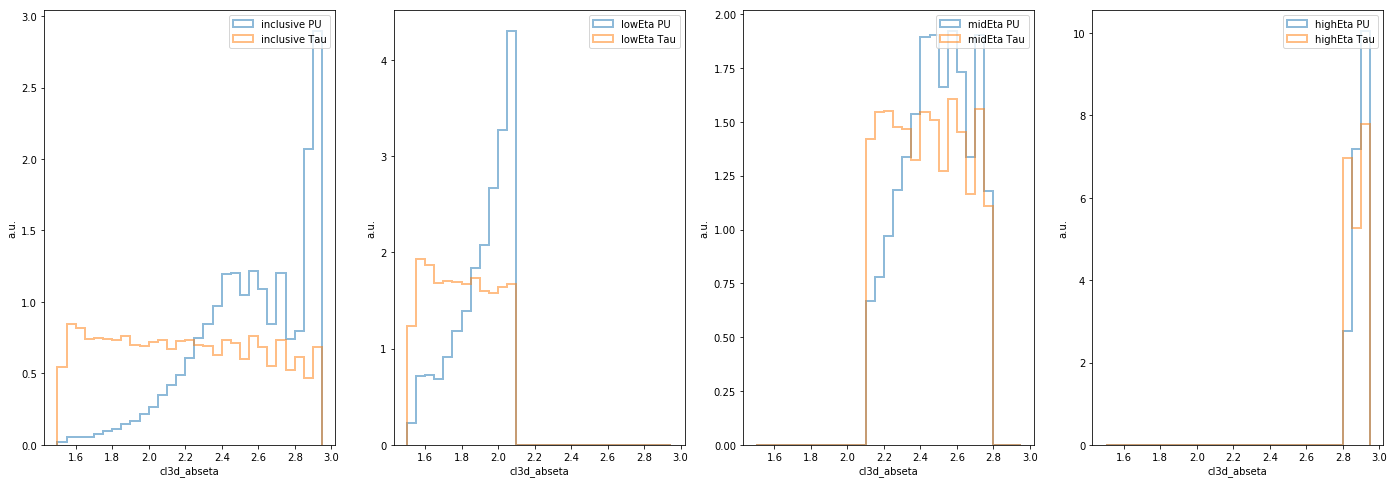

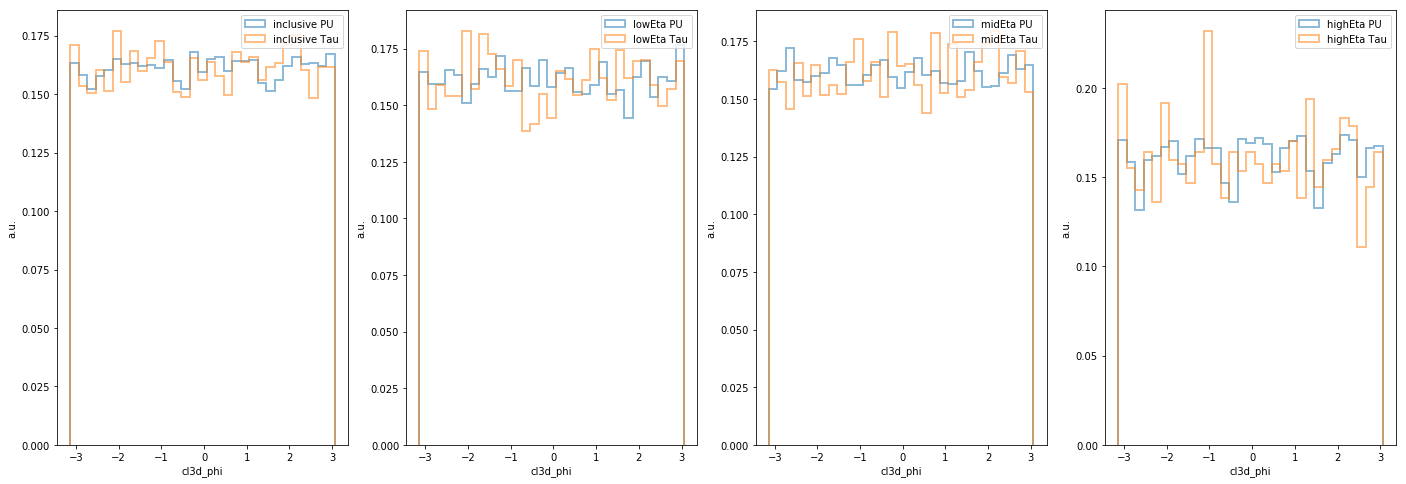

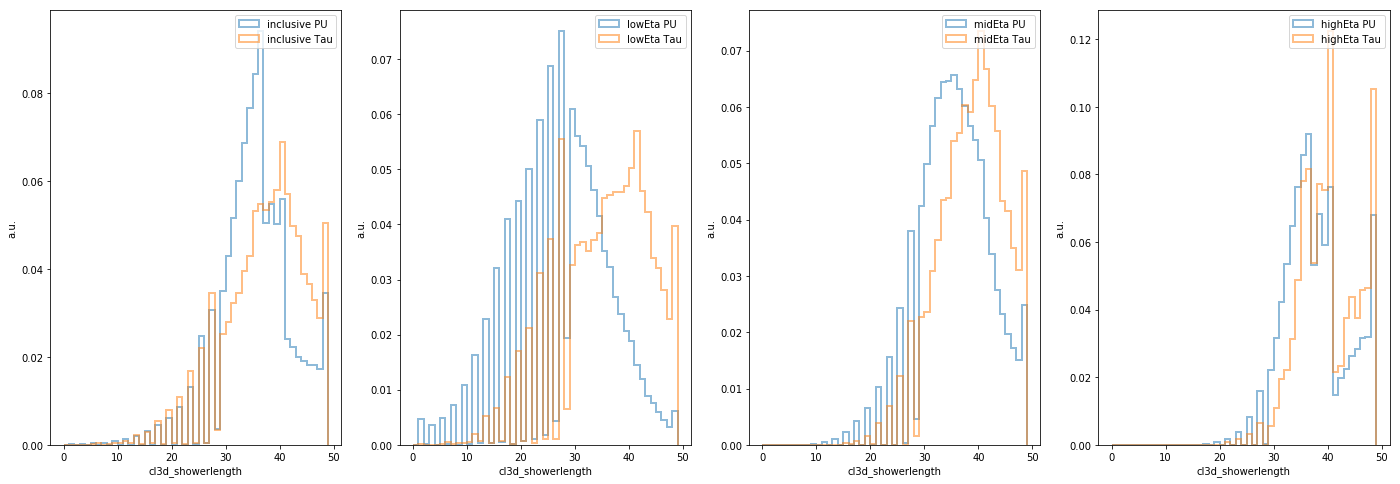

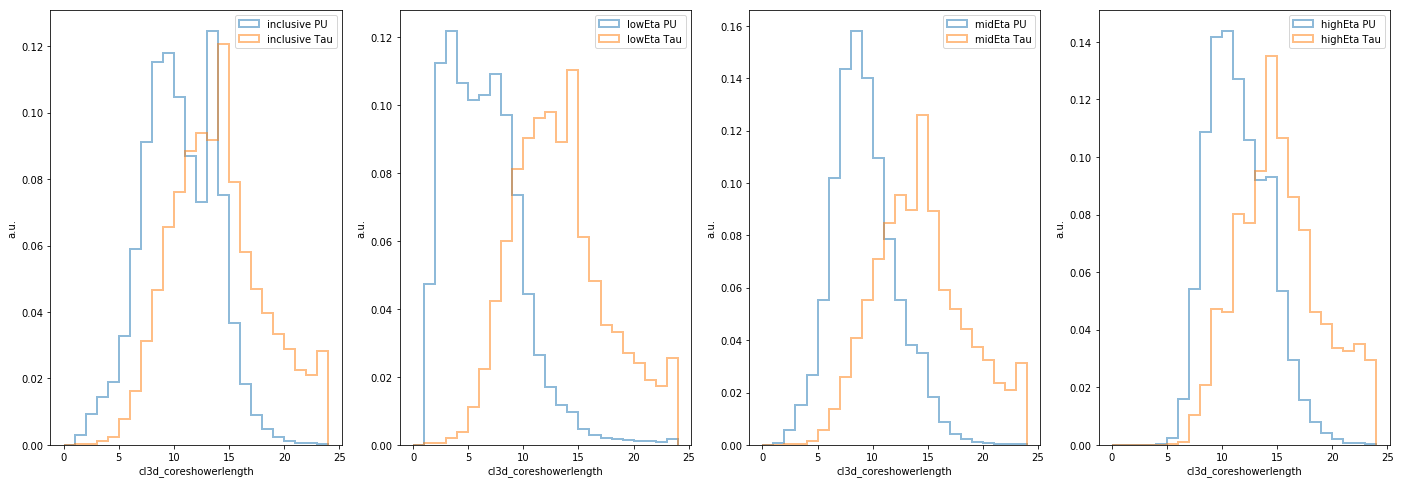

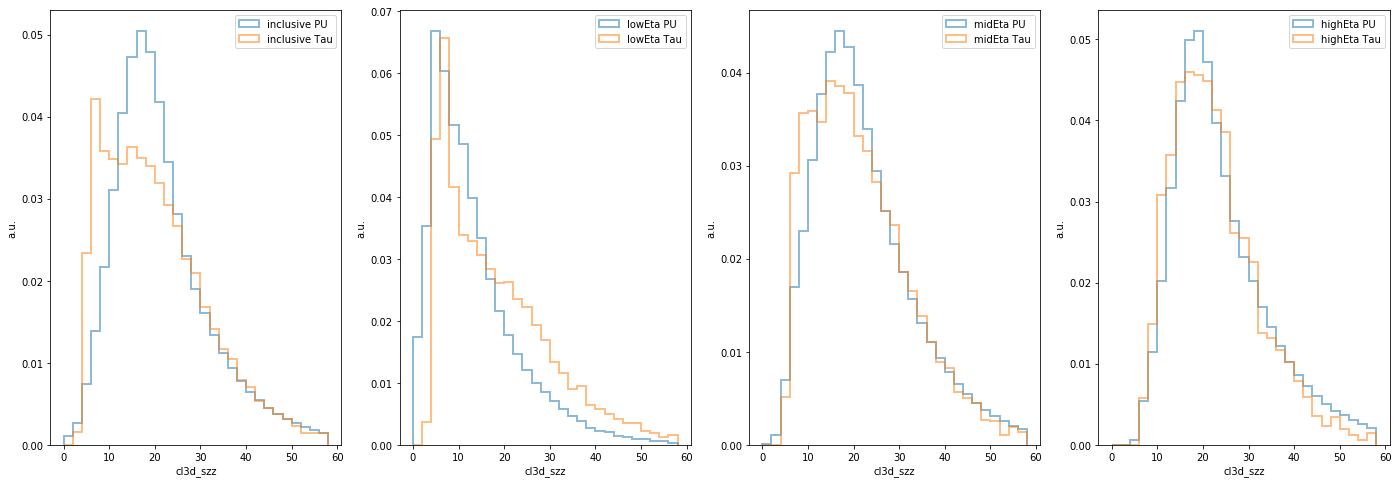

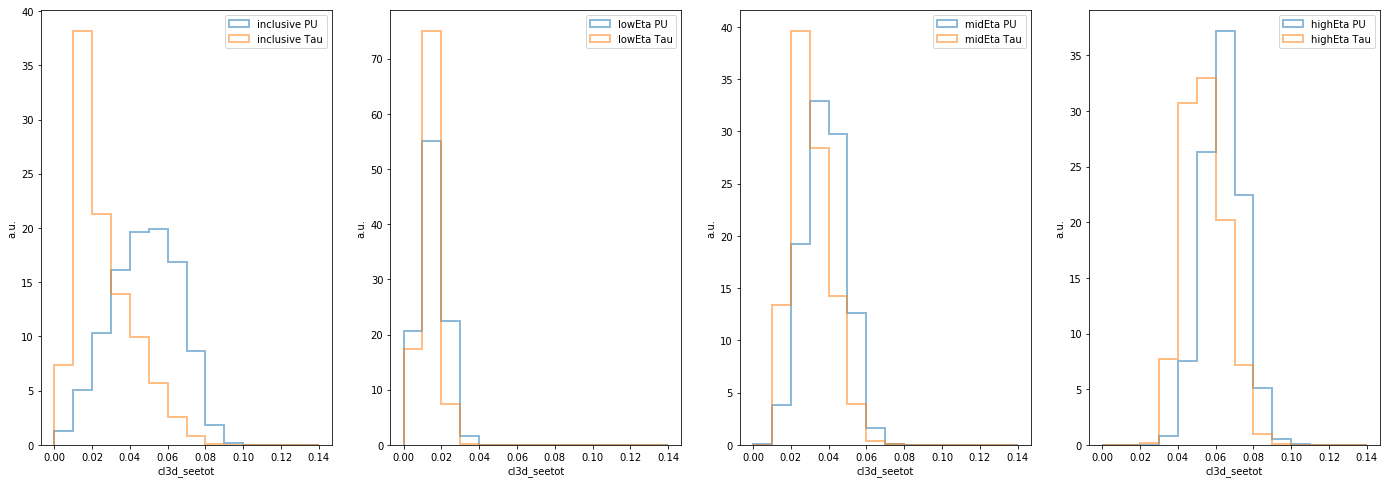

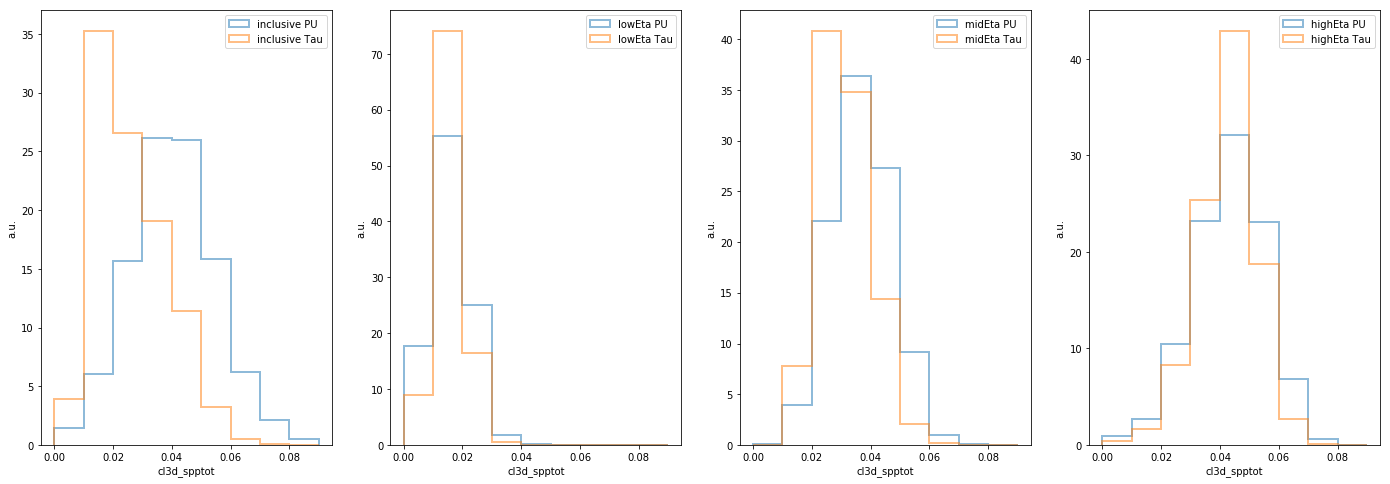

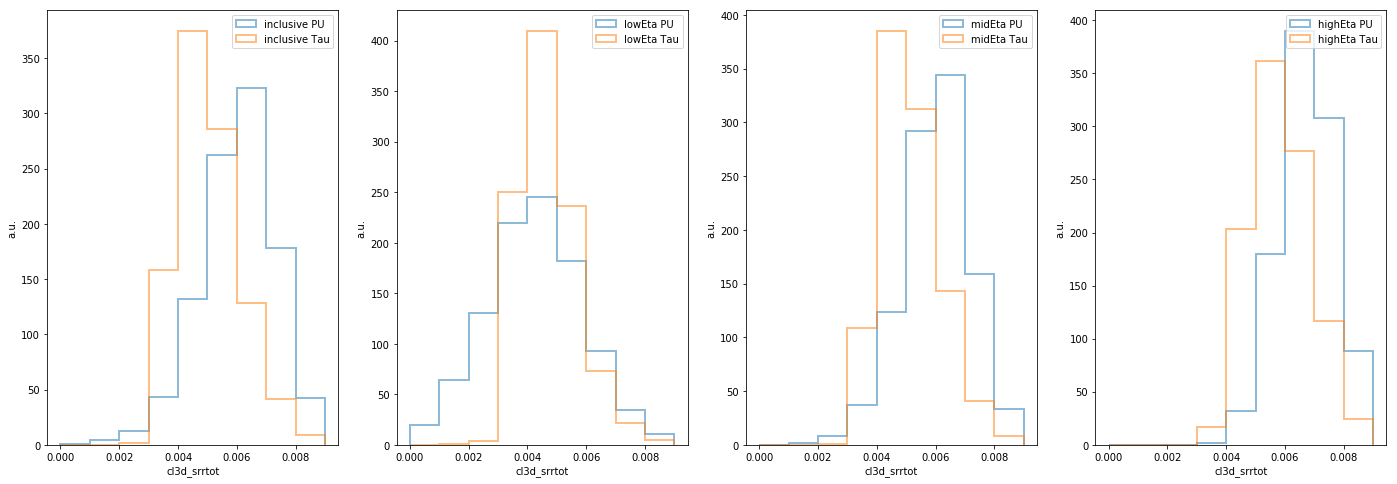

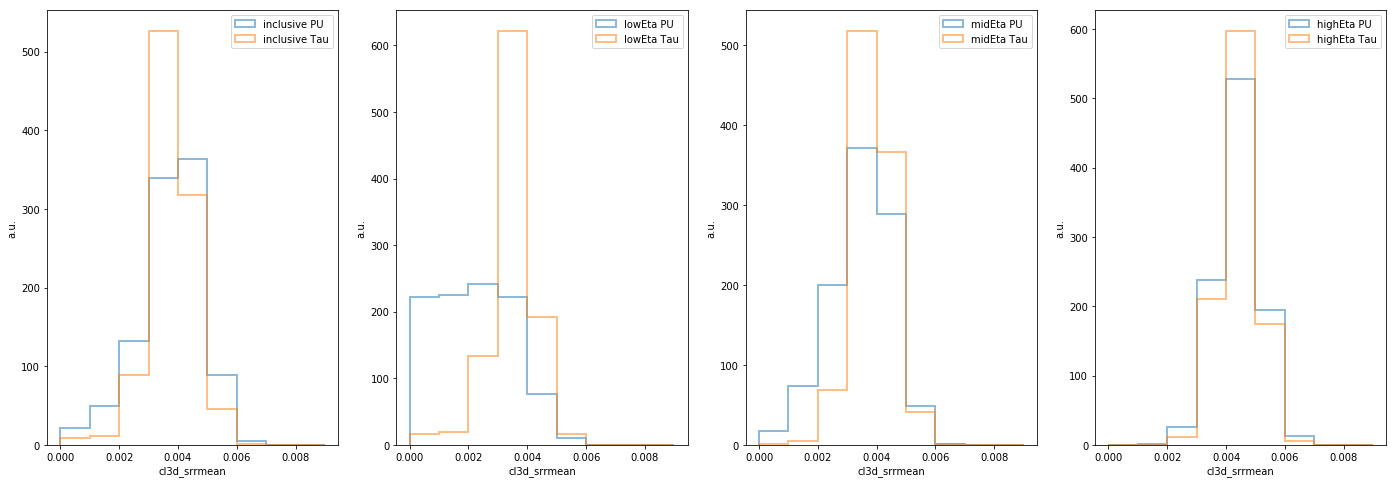

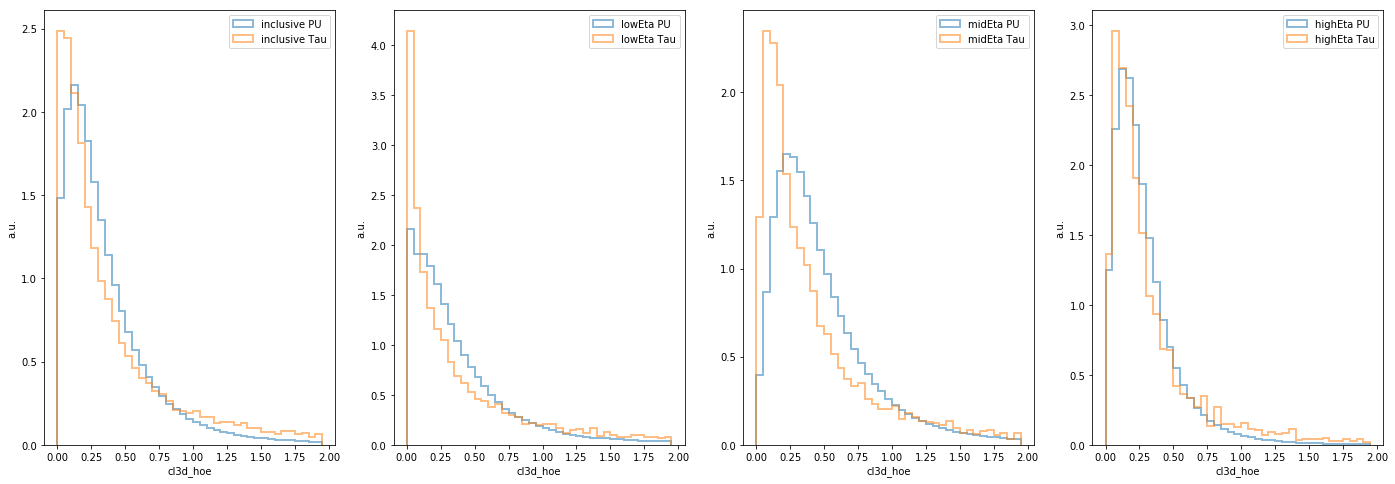

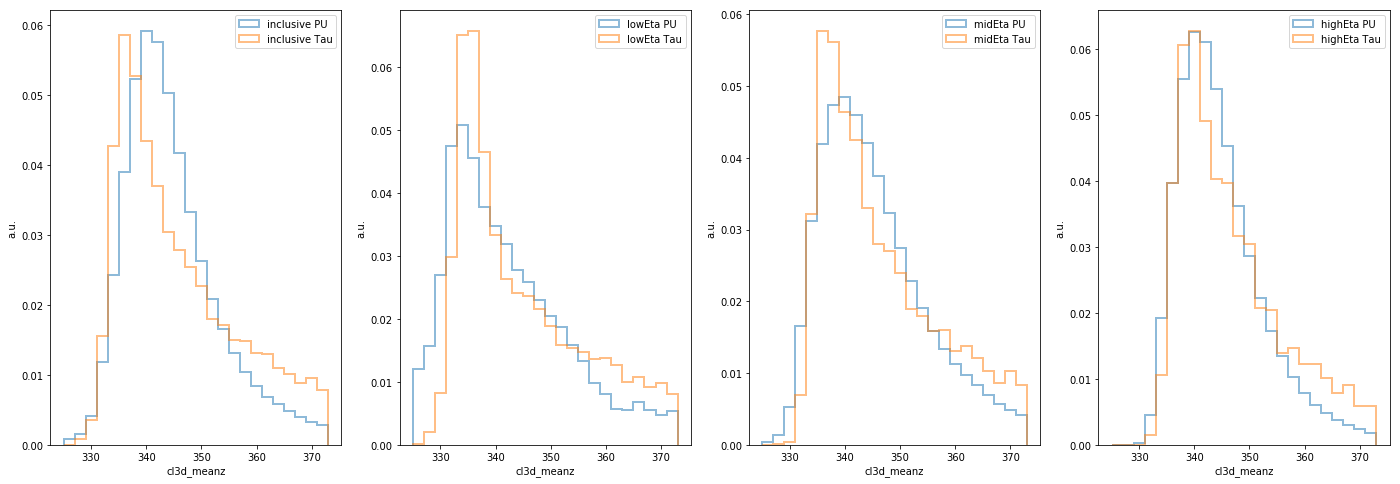

In [29]:
plotter3(dfPU, dfTau, 'cl3d_pt', np.arange(4,20,1))
plotter3(dfPU, dfTau, 'cl3d_abseta', np.arange(1.5,3.0,0.05))
plotter3(dfPU, dfTau, 'cl3d_phi', np.arange(-3.14,3.14,0.2))
plotter3(dfPU, dfTau, 'cl3d_showerlength', np.arange(0,50,1))
plotter3(dfPU, dfTau, 'cl3d_coreshowerlength', np.arange(0,25,1))
plotter3(dfPU, dfTau, 'cl3d_szz', np.arange(0,60,2))
plotter3(dfPU, dfTau, 'cl3d_seetot', np.arange(0,0.15,0.01))
plotter3(dfPU, dfTau, 'cl3d_spptot', np.arange(0,0.1,0.01))
plotter3(dfPU, dfTau, 'cl3d_srrtot', np.arange(0,0.01,0.001))
plotter3(dfPU, dfTau, 'cl3d_srrmean', np.arange(0,0.01,0.001))
plotter3(dfPU, dfTau, 'cl3d_hoe', np.arange(0,2,0.05))
plotter3(dfPU, dfTau, 'cl3d_meanz', np.arange(325,375,2))